<a href="https://colab.research.google.com/github/dejuakim/PROJECT_aiffel/blob/master/MachineLearning_MainQuest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용카드 사기 탐지 분류 문제


In [1]:
!pip uninstall -y xgboost lightgbm

Found existing installation: xgboost 1.5.0
Uninstalling xgboost-1.5.0:
  Successfully uninstalled xgboost-1.5.0
Found existing installation: lightgbm 3.3.2
Uninstalling lightgbm-3.3.2:
  Successfully uninstalled lightgbm-3.3.2


In [2]:
!pip install xgboost==1.5.0 lightgbm==3.3.2

  Using cached xgboost-1.5.0-py3-none-manylinux2014_x86_64.whl.metadata (1.7 kB)
  Using cached lightgbm-3.3.2-py3-none-manylinux1_x86_64.whl.metadata (15 kB)
Using cached xgboost-1.5.0-py3-none-manylinux2014_x86_64.whl (173.5 MB)
Using cached lightgbm-3.3.2-py3-none-manylinux1_x86_64.whl (2.0 MB)


In [3]:
!pip install hyperopt

## 데이터 이해하기

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [5]:
train_df.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [7]:
# Class 컬럼(사기 여부) 비율 확인
print('타겟 값 분포:')
print(train_df['Class'].value_counts())
print('\n타겟 값 비율(%):')
print(train_df['Class'].value_counts(normalize=True) * 100)

타겟 값 분포:
Class
0    170523
1       360
Name: count, dtype: int64

타겟 값 비율(%):
Class
0    99.78933
1     0.21067
Name: proportion, dtype: float64


## 클래스 불균형 시각화

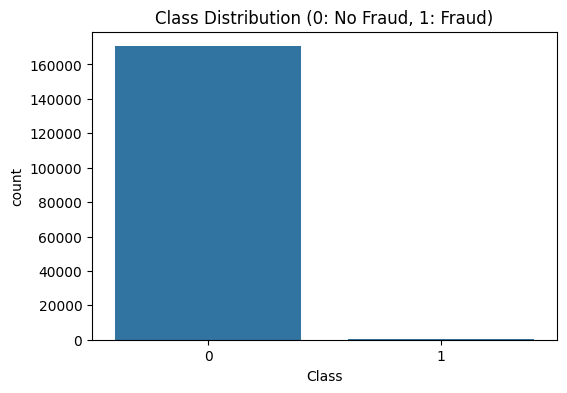

In [8]:
# 시각화로 불균형 확인
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=train_df)
plt.title('Class Distribution (0: No Fraud, 1: Fraud)')
plt.show()

In [9]:
train_df.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,...,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,...,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,...,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,...,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,...,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


## 데이터 전처리

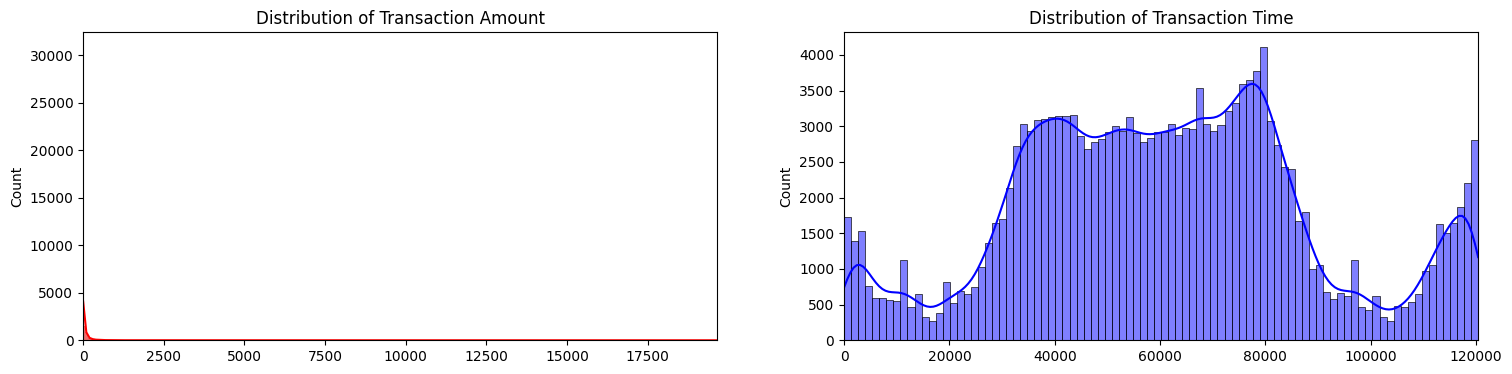

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

# Amount(거래액) 분포 확인
amount_val = train_df['Amount'].values
sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Amount')
ax[0].set_xlim([min(amount_val), max(amount_val)])

# Time(시간) 분포 확인
time_val = train_df['Time'].values
sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time')
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

Amount(거래액) 데이터의 쏠림 현상이 심각함
- 데이터가 거의 0원 근처에 몰려있고 꼬리가 오른쪽으로 길게 늘어짐

Time(시간) 분포는 두개의 산봉우리 형태
- 카드를 많이 쓰는 낮과 밤의 주기가 반영 된 것으로 보임

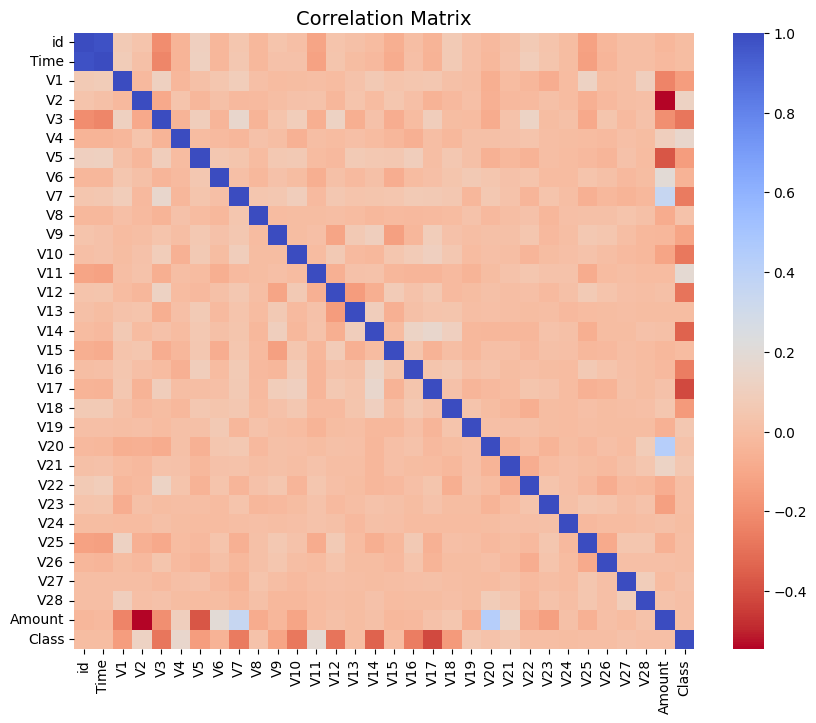

In [11]:
plt.figure(figsize=(10, 8))
corr = train_df.corr()
# Class와 상관관계가 높은 순서대로 히트맵 그리기
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.title("Correlation Matrix", fontsize=14)
plt.show()

진한 빨간색 (음의 상관관계): V17, V14, V12, V10
- 의미: 이 변수들의 값이 작아질수록(마이너스로 갈수록) 사기(Class=1)일 확률이 높아짐

파란색 (양의 상관관계): V11, V4
- 의미: 이 변수들의 값이 커질수록(플러스로 갈수록) 사기(Class=1)일 확률이 높아짐

Amount (거래액)
- 금액이 크다고 무조건 사기인 것은 아님
- Amount는 PCA를 하지 않아 V2, V5, V7, V20등 특정 변수와 관련이 있어 보임

In [12]:
train_copy = train_df.copy()
train_copy = train_copy.drop('id', axis=1)

In [13]:
test_id = test_df['id']

In [14]:
test_df = test_df.drop('id', axis=1)

In [15]:
scaler = StandardScaler()

In [16]:
# train_copy 스케일링 (학습 + 변환)
train_copy['scaled_amount'] = scaler.fit_transform(train_copy['Amount'].values.reshape(-1, 1))
train_copy['scaled_time'] = scaler.fit_transform(train_copy['Time'].values.reshape(-1, 1))

In [17]:
# test_df 스케일링 (변환만!)
test_df['scaled_amount'] = scaler.transform(test_df['Amount'].values.reshape(-1, 1))
test_df['scaled_time'] = scaler.transform(test_df['Time'].values.reshape(-1, 1))

In [18]:
# 원본 'Amount', 'Time' 삭제
train_copy = train_copy.drop(['Amount', 'Time'], axis=1)
test_df = test_df.drop(['Amount', 'Time'], axis=1)

In [19]:
train_copy.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.253232,-2.195325
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.344157,-2.195325
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.184464,-2.195289
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.147033,-2.195289
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.070528,-2.195253


## 데이터 나누기 (X, y)

In [20]:
X_features = train_copy.drop('Class', axis=1)
y_target = train_copy['Class']

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [22]:
print('학습 데이터 간 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('검증 데이터 간 레이블 값 비율')
print(y_val.value_counts()/y_val.shape[0] * 100)

학습 데이터 간 레이블 값 비율
Class
0    99.789329
1     0.210671
Name: count, dtype: float64
검증 데이터 간 레이블 값 비율
Class
0    99.789332
1     0.210668
Name: count, dtype: float64


## 불균형 처리
SMOTE 적용하기

In [23]:
# SMOTE 객체 생성
smote = SMOTE(random_state=42)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# 결과 확인
print("SMOTE 적용 전:", y_train.value_counts())
print("SMOTE 적용 후:", y_train_over.value_counts())

SMOTE 적용 전: Class
0    136418
1       288
Name: count, dtype: int64
SMOTE 적용 후: Class
0    136418
1    136418
Name: count, dtype: int64


## 모델 정의

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [25]:
# 평가 함수 정의

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬(Confusion Matrix)')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')
    print("-" * 50)

In [28]:
# 개별 모델 정의
# 1) 로지스틱 회귀
lr_clf = LogisticRegression(
    max_iter=1000,
    penalty='l2', # L2 규제 = Ridge
    C=0.01,       # 규제 강도 (작을수록 강함 >> 과적합 방지)
    random_state=42
)

# 2) 랜덤 포레스트
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,      # 깊이 제한 (과적합 방지)
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# 3) LightGBM
lgbm_clf = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.02, # 학습률을 낮추고 반복을 늘림
    num_leaves=32,
    max_depth=10,
    boost_from_average=False,
    random_state=42,
    verbose=-1 # 경고 메시지 끄기
)

models = [
    ('LR', lr_clf),
    ('RF', rf_clf),
    ('LGBM', lgbm_clf)
]

# 결과 저장용 리스트
model_performance = []

In [36]:
for name, model in models:
    print(f"[{name}] 학습 중...")
    model.fit(X_train_over, y_train_over)

    # 예측
    pred = model.predict(X_val)
    pred_proba = model.predict_proba(X_val)[:, 1]

    # 점수 출력
    get_clf_eval(y_val, pred, pred_proba)

    # 비교를 위해 저장
    f1 = f1_score(y_val, pred)
    model_performance.append({'Model': name, 'F1 Score': f1})

[LR] 학습 중...
오차 행렬(Confusion Matrix)
[[33345   760]
 [    7    65]]
정확도: 0.9776, 정밀도: 0.0788, 재현율: 0.9028, F1: 0.1449, AUC: 0.9809
--------------------------------------------------
[RF] 학습 중...
오차 행렬(Confusion Matrix)
[[34067    38]
 [    9    63]]
정확도: 0.9986, 정밀도: 0.6238, 재현율: 0.8750, F1: 0.7283, AUC: 0.9767
--------------------------------------------------
[LGBM] 학습 중...
오차 행렬(Confusion Matrix)
[[34098     7]
 [   10    62]]
정확도: 0.9995, 정밀도: 0.8986, 재현율: 0.8611, F1: 0.8794, AUC: 0.9808
--------------------------------------------------


In [37]:
# 스태킹 앙상블
# Meta Model은 로지스틱 회귀
meta_model = LogisticRegression(C=1.0, penalty='l2')

# 스태킹 모델 정의
stack_clf = StackingClassifier(
    estimators=models,       # 위에서 만든 3개 모델 (LR, RF, LGBM)
    final_estimator=meta_model, # 최종 판단 모델
    n_jobs=-1,
    cv=3                     # 내부 교차 검증 (과적합 방지)
)

print("스태킹 모델 학습 시작")
stack_clf.fit(X_train_over, y_train_over)

# 예측
stack_pred = stack_clf.predict(X_val)
stack_pred_proba = stack_clf.predict_proba(X_val)[:, 1]

# 최종 점수 출력
print(f"[Stacking] 결과:")
get_clf_eval(y_val, stack_pred, stack_pred_proba)

# 비교를 위해 저장
model_performance.append({'Model': 'Stacking', 'F1 Score': f1_score(y_val, stack_pred)})

스태킹 모델 학습 시작
[Stacking] 결과:
오차 행렬(Confusion Matrix)
[[34099     6]
 [   10    62]]
정확도: 0.9995, 정밀도: 0.9118, 재현율: 0.8611, F1: 0.8857, AUC: 0.9763
--------------------------------------------------


In [38]:
# 최종 요약표 출력
result_df = pd.DataFrame(model_performance).sort_values(by='F1 Score', ascending=False)
print("\n [최종 성적표] F1 Score 기준 순위 ")
print(result_df)


 [최종 성적표] F1 Score 기준 순위 
      Model  F1 Score
3  Stacking  0.885714
7  Stacking  0.885714
6      LGBM  0.879433
2      LGBM  0.879433
5        RF  0.728324
1        RF  0.728324
0        LR  0.144928
4        LR  0.144928


In [39]:
# 스태킹 모델로 예측
final_pred = stack_clf.predict(test_df)

# 제출용 DataFrame
submission = pd.DataFrame({
    "id": test_id,
    "Class": final_pred  # 스태킹 모델의 예측값
})

# csv 파일 저장
submission.to_csv("submission.csv", index=False)

print("제출 파일 생성 완료! (submission.csv)")
print(submission.head())

제출 파일 생성 완료! (submission.csv)
       id  Class
0  170883      0
1  170884      0
2  170885      0
3  170886      0
4  170887      0


In [40]:
from sklearn.preprocessing import Binarizer

# 스태킹 모델의 '확률' 뽑기
pred_proba = stack_clf.predict_proba(X_val)[:, 1]

# 임계값을 0.3부터 0.9까지 0.05 단위로 바꿔가며 테스트
thresholds = np.arange(0.3, 0.9, 0.05)

print("임계값별 F1 Score 변화:")
best_score = 0
best_thresh = 0.5

for thr in thresholds:
    # 해당 임계값보다 크면 1, 작으면 0으로 변환
    binarizer = Binarizer(threshold=thr)
    pred_thr = binarizer.fit_transform(pred_proba.reshape(-1, 1))

    # 점수 계산
    f1 = f1_score(y_val, pred_thr)
    print(f"Threshold {thr:.2f} : F1 Score = {f1:.4f}")

    # 신기록 갱신하면 저장
    if f1 > best_score:
        best_score = f1
        best_thresh = thr

print(f"\n최고의 임계값: {best_thresh} (점수: {best_score:.4f})")

임계값별 F1 Score 변화:
Threshold 0.30 : F1 Score = 0.8732
Threshold 0.35 : F1 Score = 0.8732
Threshold 0.40 : F1 Score = 0.8732
Threshold 0.45 : F1 Score = 0.8857
Threshold 0.50 : F1 Score = 0.8857
Threshold 0.55 : F1 Score = 0.8857
Threshold 0.60 : F1 Score = 0.8857
Threshold 0.65 : F1 Score = 0.8857
Threshold 0.70 : F1 Score = 0.8857
Threshold 0.75 : F1 Score = 0.8921
Threshold 0.80 : F1 Score = 0.8921
Threshold 0.85 : F1 Score = 0.8921
Threshold 0.90 : F1 Score = 0.8921

최고의 임계값: 0.7499999999999999 (점수: 0.8921)


In [41]:
# 스태킹 모델로 예측
final_prob = stack_clf.predict_proba(test_df)[:, 1]

# 찾은 최적의 임계값(0.75) 적용
custom_threshold = 0.75

print(f"Threshold {custom_threshold} 적용 중...")
binarizer = Binarizer(threshold=custom_threshold)
final_pred_tuned = binarizer.fit_transform(final_prob.reshape(-1, 1))

# 제출 파일 생성
submission_tuned = pd.DataFrame({
    "id": test_id,
    "Class": final_pred_tuned.astype(int).flatten()
})

# 4. 저장
submission_tuned.to_csv("submission_tuned_0.75.csv", index=False)

print("최종 파일 생성 완료: submission_tuned_0.75.csv")
print(submission_tuned.head())

Threshold 0.75 적용 중...
최종 파일 생성 완료: submission_tuned_0.75.csv
       id  Class
0  170883      0
1  170884      0
2  170885      0
3  170886      0
4  170887      0


In [42]:
# LightGBM 모델로 예측
print("LGBM 단일 모델 예측 중...")
lgbm_pred = lgbm_clf.predict(test_df)

# 2. 제출 파일 생성
submission_lgbm = pd.DataFrame({
    "id": test_id,
    "Class": lgbm_pred
})

submission_lgbm.to_csv("submission_lgbm.csv", index=False)
print("submission_lgbm.csv 생성 완료!")

LGBM 단일 모델 예측 중...
submission_lgbm.csv 생성 완료!


In [45]:
# 스태킹 모델로 예측
final_prob = stack_clf.predict_proba(test_df)[:, 1]

# 임계값(0.35) 수정
low_threshold = 0.35

print(f"Threshold {custom_threshold} 적용 중...")
binarizer = Binarizer(threshold=low_threshold)
final_pred_tuned = binarizer.fit_transform(final_prob.reshape(-1, 1))

# 제출 파일 생성
submission_tuned = pd.DataFrame({
    "id": test_id,
    "Class": final_pred_tuned.astype(int).flatten()
})

# 4. 저장
submission_tuned.to_csv("submission_tuned_0.35.csv", index=False)

print("최종 파일 생성 완료: submission_tuned_0.35.csv")

Threshold 0.35 적용 중...
최종 파일 생성 완료: submission_tuned_0.35.csv


V17   -0.409708
V14   -0.342828
V12   -0.288549
V3    -0.280022
V10   -0.276600
Name: Class, dtype: float64


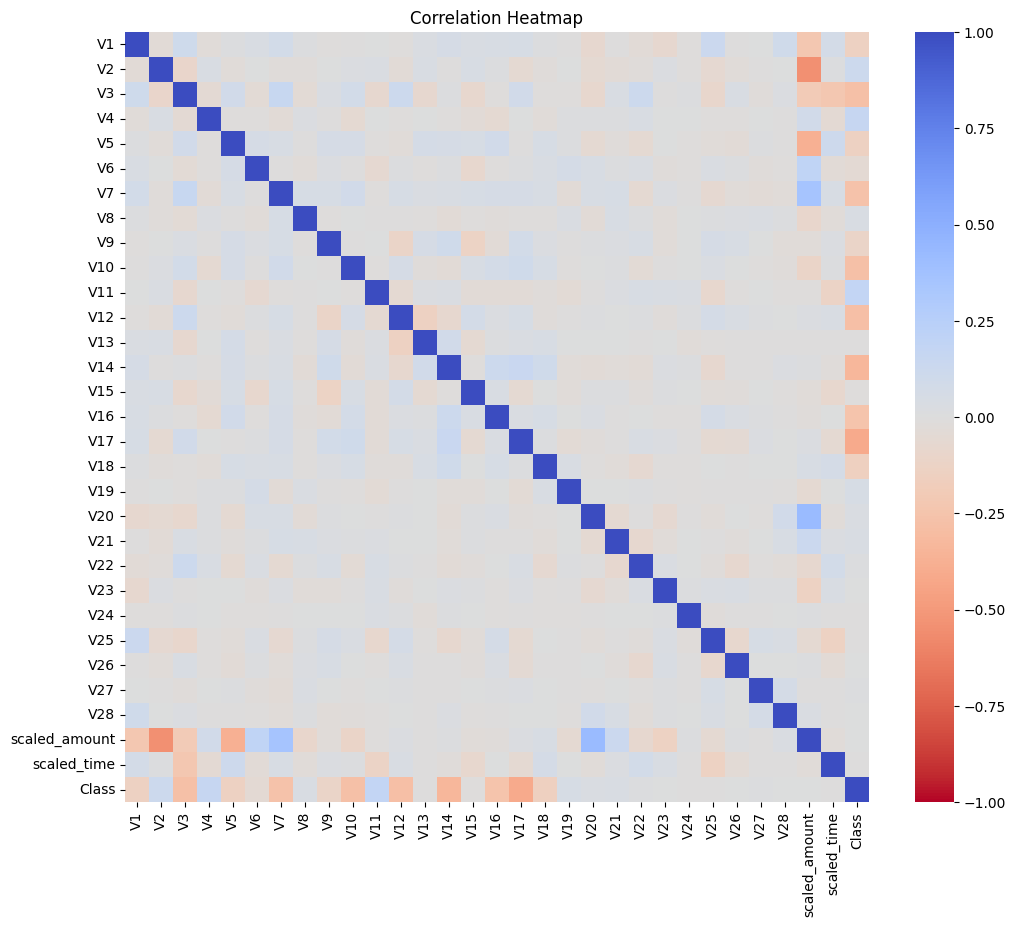

In [48]:
corr_df = X_train.copy()
corr_df['Class'] = y_train

plt.figure(figsize=(12, 10))
# 상관관계 계산
corr = corr_df.corr()

# 사기(Class)와 상관관계가 높은 순서대로 출력
print(corr['Class'].sort_values().head(5))

# 히트맵 그리기
sns.heatmap(corr, cmap='coolwarm_r', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [49]:
# 이상치 인덱스 찾기
def get_outlier(df=None, column=None, weight=1.5):
    # 사기 데이터(Class=1)만 추출
    fraud = df[df['Class'] == 1][column]

    # 25 분위수(Q1), 75 분위수(Q3) 구하기
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    # IQR(몸통 길이) 계산
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight

    # 최솟값과 최댓값 경계 설정
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    # 이 경계를 벗어나는 '사기 데이터'의 인덱스 찾기
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index

    return outlier_index

In [59]:
# 이상치 제거

# 데이터 임시 합치기
train_temp = X_train.copy()
train_temp['Class'] = y_train

# V14 컬럼에서 이상치 찾기
outlier_index_v17 = get_outlier(df=train_temp, column='V17', weight=1.5)
print(f"   - 발견된 이상치 개수: {len(outlier_index_v17)}개")

   - 발견된 이상치 개수: 0개


In [47]:
# 이상치 제거

# 데이터 임시 합치기
train_temp = X_train.copy()
train_temp['Class'] = y_train

# V14 컬럼에서 이상치 찾기
outlier_index_v14 = get_outlier(df=train_temp, column='V14', weight=1.5)
print(f"   - 발견된 이상치 개수: {len(outlier_index_v14)}개")

# 이상치 삭제
train_clean = train_temp.drop(outlier_index_v14, axis=0)
print(f"   - 제거 후 데이터 개수: {len(train_temp)} -> {len(train_clean)}")

# 다시 분리
X_train_clean = train_clean.drop('Class', axis=1)
y_train_clean = train_clean['Class']

   - 발견된 이상치 개수: 1개
   - 제거 후 데이터 개수: 136706 -> 136705


In [57]:
print("SMOTE 재적용")
smote = SMOTE(random_state=42)
X_train_over_clean, y_train_over_clean = smote.fit_resample(X_train_clean, y_train_clean)

# 스태킹 모델 재학습
print("스태킹 모델 재학습 시작...")
# 모델 초기화
lr_clf = LogisticRegression(max_iter=1000, penalty='l2', C=0.01, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=-1)
lgbm_clf = LGBMClassifier(n_estimators=1000, learning_rate=0.02, num_leaves=32, max_depth=10, boost_from_average=False, random_state=42, verbose=-1)

models = [('LR', lr_clf), ('RF', rf_clf), ('LGBM', lgbm_clf)]
meta_model = LogisticRegression(C=1.0, penalty='l2')

stack_clf_clean = StackingClassifier(
    estimators=models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

stack_clf_clean.fit(X_train_over_clean, y_train_over_clean)

prob_clean = stack_clf_clean.predict_proba(X_val)[:, 1]

# 수정 임계값 (0.35) 결과
print("\n수정 임계값 (0.35)")
custom_threshold = 0.35
binarizer = Binarizer(threshold=custom_threshold)
pred_tuned = binarizer.fit_transform(prob_clean.reshape(-1, 1))

get_clf_eval(y_val, pred_tuned, prob_clean)

SMOTE 재적용
스태킹 모델 재학습 시작...

수정 임계값 (0.35)
오차 행렬(Confusion Matrix)
[[34097     8]
 [   10    62]]
정확도: 0.9995, 정밀도: 0.8857, 재현율: 0.8611, F1: 0.8732, AUC: 0.9759
--------------------------------------------------


In [58]:
final_prob = stack_clf_clean.predict_proba(test_df)[:, 1]

custom_threshold = 0.35
binarizer = Binarizer(threshold=custom_threshold)
final_pred_clean = binarizer.fit_transform(final_prob.reshape(-1, 1))

submission_clean = pd.DataFrame({
    "id": test_id,
    "Class": final_pred_clean.astype(int).flatten()
})

submission_clean.to_csv("submission_outlier_clean_0.35.csv", index=False)

이상치 제거 후 성능 저하됨

CatBoost 실행으로 전략 변경

In [60]:
try:
    from catboost import CatBoostClassifier
except ImportError:
    !pip install catboost
    from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00


In [61]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"CatBoost 가중치 설정: 사기 데이터 1개를 정상 데이터 {ratio:.2f}개 처럼 취급합니다.")

CatBoost 가중치 설정: 사기 데이터 1개를 정상 데이터 473.67개 처럼 취급합니다.


In [62]:
# CatBoost 모델 정의 및 학습
cat_clf = CatBoostClassifier(
    iterations=2000,          # 반복 횟수 (충분히 많이)
    learning_rate=0.02,       # 학습률 (천천히 꼼꼼하게)
    depth=8,                  # 트리의 깊이
    l2_leaf_reg=3,            # 규제 (과적합 방지)
    loss_function='Logloss',
    eval_metric='F1',         # F1 점수를 최우선으로
    scale_pos_weight=ratio,   # 불균형 해결
    random_seed=42,
    verbose=200,              # 200번마다 로그 출력
    early_stopping_rounds=100 # 더 이상 안 좋아지면 조기 종료
)

print("\nCatBoost 학습 시작")
cat_clf.fit(X_train, y_train, eval_set=(X_val, y_val))

# 성능평가
print("\n[CatBoost 검증 결과]")
pred_cat = cat_clf.predict(X_val)
pred_proba_cat = cat_clf.predict_proba(X_val)[:, 1]

# 작성해주신 함수 호출
get_clf_eval(y_val, pred_cat, pred_proba_cat)


CatBoost 학습 시작
0:	learn: 0.9428641	test: 0.9216090	best: 0.9216090 (0)	total: 352ms	remaining: 11m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.939805123
bestIteration = 16

Shrink model to first 17 iterations.

[CatBoost 검증 결과]
오차 행렬(Confusion Matrix)
[[34011    94]
 [    8    64]]
정확도: 0.9970, 정밀도: 0.4051, 재현율: 0.8889, F1: 0.5565, AUC: 0.9740
--------------------------------------------------


In [63]:
# CatBoost가 예측한 확률값 가져오기
prob_cat = cat_clf.predict_proba(X_val)[:, 1]

# 임계값을 0.5부터 0.99까지 촘촘하게 검사
thresholds = np.arange(0.5, 0.99, 0.05)

print("가중치 적용 모델의 최적 임계값 찾기")
best_score = 0
best_thresh = 0.5

for thr in thresholds:
    binarizer = Binarizer(threshold=thr)
    pred_thr = binarizer.fit_transform(prob_cat.reshape(-1, 1))

    f1 = f1_score(y_val, pred_thr)
    print(f"Threshold {thr:.2f} : F1 Score = {f1:.4f}")

    if f1 > best_score:
        best_score = f1
        best_thresh = thr

print(f"\nBest Threshold: {best_thresh:.2f}")
print(f"   (F1 점수: {best_score:.4f})")

가중치 적용 모델의 최적 임계값 찾기
Threshold 0.50 : F1 Score = 0.5565
Threshold 0.55 : F1 Score = 0.6738
Threshold 0.60 : F1 Score = 0.7607
Threshold 0.65 : F1 Score = 0.8052
Threshold 0.70 : F1 Score = 0.8299
Threshold 0.75 : F1 Score = 0.8112
Threshold 0.80 : F1 Score = 0.8085
Threshold 0.85 : F1 Score = 0.7424
Threshold 0.90 : F1 Score = 0.0274
Threshold 0.95 : F1 Score = 0.0000

Best Threshold: 0.70
   (F1 점수: 0.8299)


In [64]:
# CatBoost 모델 재정의 (가중치 옵션 삭제)
cat_smote = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.02,
    depth=8,
    l2_leaf_reg=3,
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=42,
    verbose=200,
    early_stopping_rounds=100
)

print("CatBoost + SMOTE 학습 시작...")
cat_smote.fit(X_train_over, y_train_over, eval_set=(X_val, y_val))

# 성능 평가
print("\n[CatBoost + SMOTE 결과]")
pred_smote = cat_smote.predict(X_val)
prob_smote = cat_smote.predict_proba(X_val)[:, 1]

get_clf_eval(y_val, pred_smote, prob_smote)

CatBoost + SMOTE 학습 시작...
0:	learn: 0.9546014	test: 0.1054313	best: 0.1054313 (0)	total: 160ms	remaining: 5m 19s
200:	learn: 0.9989710	test: 0.6086957	best: 0.6146341 (198)	total: 28.7s	remaining: 4m 17s
400:	learn: 0.9996483	test: 0.7159091	best: 0.7159091 (383)	total: 54.1s	remaining: 3m 35s
600:	learn: 0.9997911	test: 0.7544910	best: 0.7636364 (536)	total: 1m 20s	remaining: 3m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7636363636
bestIteration = 536

Shrink model to first 537 iterations.

[CatBoost + SMOTE 결과]
오차 행렬(Confusion Matrix)
[[34075    30]
 [    9    63]]
정확도: 0.9989, 정밀도: 0.6774, 재현율: 0.8750, F1: 0.7636, AUC: 0.9807
--------------------------------------------------


정밀도 무너짐...

성능이 좋았던 Stacking과 LightGBM으로 다시 도전

In [65]:
# 모델 재정의
lr_clf = LogisticRegression(max_iter=1000, penalty='l2', C=0.01, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=-1)
lgbm_clf = LGBMClassifier(n_estimators=1000, learning_rate=0.02, num_leaves=32, max_depth=10, boost_from_average=False, random_state=42, verbose=-1)

# LightGBM 단독 학습
lgbm_clf.fit(X_train_over, y_train_over)

# Stacking 학습
stack_models = [('LR', lr_clf), ('RF', rf_clf), ('LGBM', lgbm_clf)]
meta_model = LogisticRegression(C=1.0, penalty='l2')

stack_clf = StackingClassifier(
    estimators=stack_models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)
stack_clf.fit(X_train_over, y_train_over)

StackingClassifier(cv=3,
                   estimators=[('LR',
                                LogisticRegression(C=0.01, max_iter=1000,
                                                   random_state=42)),
                               ('RF',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=5,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('LGBM',
                                LGBMClassifier(boost_from_average=False,
                                               learning_rate=0.02, max_depth=10,
                                               n_estimators=1000, num_leaves=32,
                                               random_state=42, verbose=-1))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [66]:
# 확률 예측 (Probability)
prob_lgbm = lgbm_clf.predict_proba(test_df)[:, 1]    # LGBM 의견
prob_stack = stack_clf.predict_proba(test_df)[:, 1]  # Stacking 의견

# 평균 내기
final_prob = (prob_lgbm + prob_stack) / 2

# 최적의 임계값 적용
threshold = 0.45

binarizer = Binarizer(threshold=threshold)
final_pred = binarizer.fit_transform(final_prob.reshape(-1, 1))

# 제출 파일 생성
submission_blend = pd.DataFrame({
    "id": test_id,
    "Class": final_pred.astype(int).flatten()
})

submission_blend.to_csv("submission_final_blend.csv", index=False)
print("submission_final_blend.csv 파일 생성 완료!")
print(submission_blend.head())

submission_final_blend.csv 파일 생성 완료!
       id  Class
0  170883      0
1  170884      0
2  170885      0
3  170886      0
4  170887      0


LightGBM 하이퍼파라미터 튜닝 (GridSearchCV)

In [67]:
from sklearn.model_selection import GridSearchCV

lgbm = LGBMClassifier(boost_from_average=False, random_state=42, verbose=-1)

# 테스트해볼 파라미터 조합
param_grid = {
    'n_estimators': [500, 1000],        # 나무 개수
    'learning_rate': [0.01, 0.02],      # 학습 속도
    'num_leaves': [32, 64],             # 나무의 복잡도
    'max_depth': [10, 20, -1]           # 나무의 깊이
}

# F1 점수를 기준으로 3번씩 테스트(cv=3)
grid_lgbm = GridSearchCV(lgbm, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid_lgbm.fit(X_train_over, y_train_over)

print(f"\n최적의 파라미터: {grid_lgbm.best_params_}")
print(f"그때의 최고 F1 점수: {grid_lgbm.best_score_:.4f}")

# 최적의 모델 저장
best_lgbm = grid_lgbm.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



최적의 파라미터: {'learning_rate': 0.02, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 64}
그때의 최고 F1 점수: 0.9998


In [68]:
# 튜닝된 모델로 스태킹 다시 만들기
# =========================================================
print("\n튜닝된 LGBM + RF + LR 스태킹")

# Random Forest도 조금 더 깊게 설정
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=3, random_state=42, n_jobs=-1)
lr_clf = LogisticRegression(max_iter=1000, penalty='l2', C=0.01, random_state=42)

# 스태킹 조립 (LGBM 자리에 방금 찾은 best_lgbm을 넣음!)
stack_models = [
    ('LR', lr_clf),
    ('RF', rf_clf),
    ('LGBM', best_lgbm)
]
meta_model = LogisticRegression(C=1.0, penalty='l2')

stack_clf_tuned = StackingClassifier(
    estimators=stack_models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

# 학습 시작
stack_clf_tuned.fit(X_train_over, y_train_over)

# 검증 데이터로 성능 확인
# =========================================================
print("\n검증 데이터(Validation Set) 성적 확인")

# 검증 데이터 확률 예측
val_prob_tuned = stack_clf_tuned.predict_proba(X_val)[:, 1]

# 임계값 적용
target_threshold = 0.45
print(f"Threshold: {target_threshold}")

binarizer = Binarizer(threshold=target_threshold)
val_pred_tuned = binarizer.fit_transform(val_prob_tuned.reshape(-1, 1))

# 성적 확인
get_clf_eval(y_val, val_pred_tuned, val_prob_tuned)


튜닝된 LGBM + RF + LR 스태킹

검증 데이터(Validation Set) 성적 확인
Threshold: 0.45
오차 행렬(Confusion Matrix)
[[34101     4]
 [    9    63]]
정확도: 0.9996, 정밀도: 0.9403, 재현율: 0.8750, F1: 0.9065, AUC: 0.9800
--------------------------------------------------


In [69]:
# 확률 예측
final_prob = stack_clf_tuned.predict_proba(test_df)[:, 1]

# 위에서 검증한 것과 동일한 임계값 적용
binarizer = Binarizer(threshold=target_threshold)
final_pred = binarizer.fit_transform(final_prob.reshape(-1, 1))

submission_tuned = pd.DataFrame({
    "id": test_id,
    "Class": final_pred.astype(int).flatten()
})

submission_tuned.to_csv("submission_tuned_stacking.csv", index=False)
print(f"최종 제출 파일 생성 완료: submission_tuned_stacking.csv")

최종 제출 파일 생성 완료: submission_tuned_stacking.csv


과대적합으로 검증 점수는 높으나 실전 문제는 형편없는 결과..

튜닝 후 검증 점수는 0.9998(만점)이었으나, 리더보드 점수는 0.78로 하락함.
- 모델이 단순 암기한 것으로 보임

오늘 마주한 문제들
- SMOTE로 생성된 가짜 데이터를 모델이 단순 암기해릴 수 있음
- GridSearch로 인한 긴 대기 시간과 답답함